In [1]:
import sys
# The path to the cloned MCEq directory (with the setup.py file)
sys.path.append('/Users/tkozynets/Software/MCEq_fork/MCEq')
from MCEq.core import MCEqRun
from MCEq.misc import reset_plt, put_ticks
import mceq_config as config

import crflux.models as pm
from particle import Particle
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import ticker

import numpy as np

### Config settings

In [2]:
config.e_min = 1e-1
config.e_max = 1e4
config.enable_2D = True
# 2D database file (has to be available in the MCEq/data folder)
config.mceq_db_fname = 'mceq_db_le_hel_lext_2D.h5'
config.enable_default_tracking = False
config.enable_em = False
config.enable_em_ion = False
config.hybrid_crossover = 0.1
config.muon_energy_loss = True
config.generic_losses_all_charged = True
config.enable_cont_rad_loss = True
config.enable_energy_loss = True
config.muon_helicity_dependence = True
config.muon_multiple_scattering = True
config.density_model = ("CORSIKA", ("USStd", None))
config.adv_set['force_resonance'] = [421, 431, 411, 310]
config.adv_set['disabled_particles'] = [22, 111, 16, 11]
config.debug_level = 5

### MCEq initialization

In [3]:
# Input cosmic ray spectrum (do dir(pm) to browse through available models)
cr_spectrum = pm.GlobalSplineFitBeta
# Angle of the shower inclination (in degrees)
theta_deg = 30.0
# High-energy hadronic interaction model 
# (choose between EPOSLHC, SIBYLL23D, DPMJETIII191)
he_model = 'EPOSLHC'

# Main MCEq object
mceq_2d = MCEqRun(
    theta_deg=theta_deg,
    interaction_model=he_model,
    primary_model=cr_spectrum,
)

dm = mceq_2d.density_model
# Energy centers of the MCEq grid
mceq_egrid = mceq_2d.e_grid
# Energy bin edges of the MCEq grid
mceq_ebins = mceq_2d.e_bins
# Number of energy bins
edim = len(mceq_2d.e_grid)
# Energy bin widths
ediffs = np.diff(mceq_ebins)

HDF5Backend::__init__(): Opening HDF5 file mceq_db_le_hel_lext_2D.h5
MCEqRun::set_interaction_model(): EPOSLHC
HDF5Backend::decay_db(): Using helicity dependent decays.
HDF5Backend::decay_db(): Replacing decay from custom decay_db.
ParticleManager::_init_categories(): Generating particle list.
ParticleManager::set_interaction_model(): Setting hadronic secondaries for particles.
ParticleManager::set_decay_channels(): Setting decay info for particles.
MatrixBuilder::construct_matrices(): Start filling matrices. Skip_decay_matrix = False
MatrixBuilder::construct_matrices(): Cont. loss for mu+_l
MatrixBuilder::construct_matrices(): Cont. loss for mu+
MatrixBuilder::construct_matrices(): Cont. loss for mu+_r
MatrixBuilder::construct_matrices(): Cont. loss for mu-_l
MatrixBuilder::construct_matrices(): Cont. loss for mu-
MatrixBuilder::construct_matrices(): Cont. loss for mu-_r
MatrixBuilder::construct_matrices(): Cont. loss for pi-
MatrixBuilder::construct_matrices(): Cont. loss for pi+
Mat

In [4]:
# Define the altitudes (in cm) where the MCEq solutions are to be recorded 
# and convert them to slant depth (in g/cm2)
save_depths = dm.h2X([1500000, 500000, 20000, 0])

In [5]:
# If necessary, reset the initial condition to a single primary particle with a fixed energy (in GeV).
# Comment this out if interested in the solutions from the original CR spectrum model passed at the init stage.
prim_energy = 100 
mceq_2d.set_single_primary_particle(prim_energy, pdg_id=2212)

MCEqRun::set_single_primary_particle(): CORSIKA ID None, PDG ID 2212, energy   100 GeV
MCEqRun::set_single_primary_particle(): superposition: n_protons=1, n_neutrons=0, energy per nucleon=  100 GeV


### Solving the 2D cascade equation

In [6]:
mceq_2d.solve(int_grid=save_depths)

MCEqRun::solve(): Launching euler solver
MCEqRun::_calculate_integration_path(): X_surface = 1195.93g/cm2
MCEqRun::solve(): for 2560 integration steps.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2560/2560 [00:21<00:00, 118.51it/s]


solv_numpy(): Performance:   8.45ms/iteration
MCEqRun::solve(): time elapsed during integration: 21.65sec


In [7]:
# Extract the solutions in the Hankel frequency space
hankel_solution_history = mceq_2d.grid_sol

### Post-processing of the solutions...

In [8]:
# Choose the particles whose angular densities you wish to reconstruct
extract_pdg = [12, 13, 14]

In [9]:
# Get the angular densities (2D) as well as the 1D MCEq solutions
mceq_2d_solutions_by_pdg = {}
mceq_1d_solutions_by_pdg = {}

for pdg in extract_pdg:
    
    mceq_1d_solutions_by_pdg[pdg] = []
    mceq_2d_solutions_by_pdg[pdg] = []
    # For muons, reconstruct all polarizations (if applicable)
    if (pdg in [13, -13]) & (config.muon_helicity_dependence == True):
        available_helicities = [-1, 0, 1]
    else:
        available_helicities = [0]
    
    for hel in available_helicities:
        # Start and end indices of the current particle in the global MCEq flux vector
        mceqidx_start = mceq_2d.pman.pdg2mceqidx[(pdg, hel)] * len(mceq_2d.e_grid)
        mceqidx_end = (mceq_2d.pman.pdg2mceqidx[(pdg, hel)] + 1) * len(mceq_2d.e_grid)
        
        mceq_2d_solutions_by_pdg[(pdg, hel)] = []
        mceq_1d_solutions_by_pdg[(pdg, hel)] = []
        
        # Convert the Hankel-space solutions to the theta-space solutions (some speedup possible here?)
        _, _, theta_range, ang_sols_vs_depth = mceq_2d.convert_to_theta_space(hankel_solution_history, pdg, hel)
        mceq_2d_solutions_by_pdg[(pdg, hel)] = np.array(ang_sols_vs_depth)
    
        for ind in range(len(save_depths)):
            hankel_transf = hankel_solution_history[ind]
            mceq_1d_solutions_by_pdg[(pdg, hel)].append(hankel_transf[0, mceqidx_start:mceqidx_end])
            
    mceq_2d_solutions_by_pdg[pdg] = np.zeros_like(mceq_2d_solutions_by_pdg[(pdg, 0)])
    mceq_1d_solutions_by_pdg[pdg] = np.zeros_like(mceq_1d_solutions_by_pdg[(pdg, 0)])
    
    # Add all polarizations together if need be (for most particles, this is redundant)
    for hel in available_helicities:
        mceq_2d_solutions_by_pdg[pdg] += mceq_2d_solutions_by_pdg[(pdg, hel)]
        mceq_1d_solutions_by_pdg[pdg] += mceq_1d_solutions_by_pdg[(pdg, hel)]

### Plot the 1D spectrum

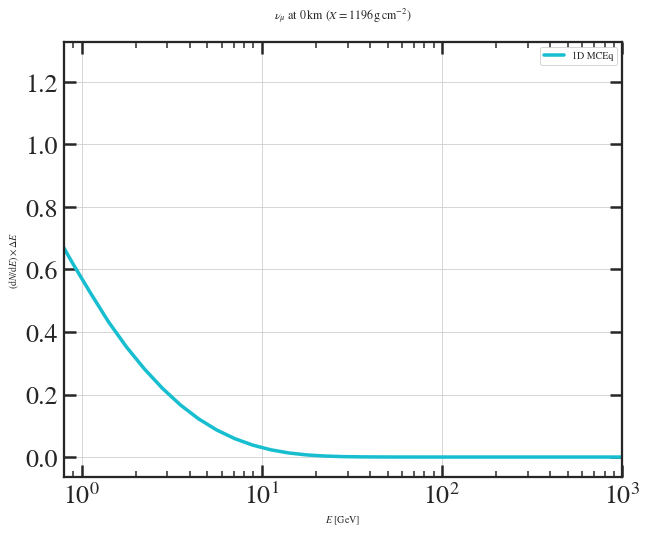

In [10]:
pdg = 14
depth_ind = 3

reset_plt(26, 26)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)

ax.plot(mceq_egrid, np.array(mceq_1d_solutions_by_pdg[pdg][depth_ind]) * ediffs, lw=3.5, label='1D MCEq', 
        color='C9')
ax.grid(True)
ax.set_xscale('log')
ax.set_xlim(0.8, 1000)

ax.set_xlabel('$E$ [GeV]')
ax.set_ylabel(r'$(\mathrm{d}N/\mathrm{d}E) \times \Delta E$')

ax.legend(loc='upper right', frameon=True)
ax.set_title(r'$%s$ at %s$\,$km ($X = %s\,\mathrm{g\,cm^{-2}}$)'%(Particle.from_pdgid(pdg).latex_name,
                                          "{:.0f}".format(int(dm.X2h(save_depths[depth_ind]) / 1e5)),
                                           "{:.0f}".format(save_depths[depth_ind])) + '\n')

put_ticks(fig, ax)

### Plot the 2D solutions

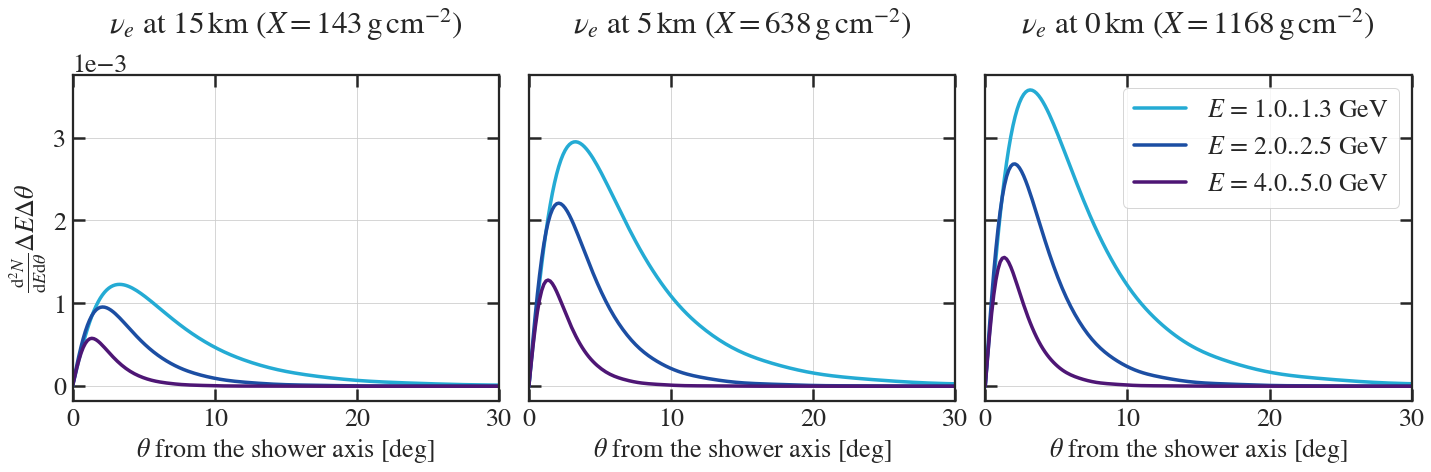

In [11]:
energies_to_plot = [1, 2, 5]
ebins_to_plot = np.digitize(energies_to_plot, mceq_ebins) - 1

pdg = 12

reset_plt(26, 26)
fig, axes = plt.subplots(1, 3,figsize = (24, 6),sharey='row')
axes = axes.flatten()

line_colors = ['#24abd4','#1c4ea3','#4e1675']

for ix in range(len(save_depths[:-1])):
    
    ax = axes[ix]   
    
    for i in range(len(energies_to_plot)):

        this_ebin = ebins_to_plot[i]
        
        # Scale the angular density by theta (to arrive at dN/dE_dtheta directly comparable to e.g. CORSIKA)
        # and convert to degrees
        this_mceq_sol = mceq_2d_solutions_by_pdg[pdg][ix][this_ebin] * theta_range * np.diff(theta_range)[0]
        
        ax.plot(np.degrees(theta_range), this_mceq_sol * ediffs[this_ebin], lw=3.5,
               color=line_colors[i], 
               label=r'$E$ = %s..%s GeV'%("{:.1f}".format(mceq_ebins[this_ebin]),
                "{:.1f}".format(mceq_ebins[this_ebin+1])))

        ax.set_title(r'$%s$ at %s$\,$km ($X = %s\,\mathrm{g\,cm^{-2}}$)'%(Particle.from_pdgid(pdg).latex_name,
                                          "{:.0f}".format(dm.X2h(save_depths[ix])/(1000 * 100)),
                                           "{:.0f}".format(save_depths[ix])) + '\n')
        ax.set_xlim(0,30)
        ax.grid(True)
        ax.set_xlabel(r'$\theta$ from the shower axis [deg]') 
        put_ticks(fig, ax)
        
        
fig.subplots_adjust(wspace=0.07)
axes[0].set_ylabel(r'$ \frac{\mathrm{d}^2N}{\mathrm{d}E\mathrm{d}\theta} \Delta E \Delta \theta \,\,$')
axes[2].legend(loc = 'upper right',frameon = True,fontsize=26)
